## VAE encoder network

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Latent space sampling function

In [2]:
def sampling(args):
    
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

## VAE decoder network, mapping latent space points to images

In [3]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

## Custom layer used to compute the VAE loss

In [4]:
class CustomVariationalModel(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        
        return K.mean(xent_loss + kl_loss)
    
    # Implementing a custom layer by writing a call method
    def call(self, inputs):
        
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        
        return x
    
y = CustomVariationalModel()([input_img, z_decoded])

## Training the VAE

In [11]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
#vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 316s 5ms/step - loss: 0.2637 - val_loss: 0.1996
Epoch 2/10
60000/60000 [==============================] - 333s 6ms/step - loss: 0.1959 - val_loss: 0.1928
Epoch 3/10
60000/60000 [==============================] - 312s 5ms/step - loss: 0.1908 - val_loss: 0.1891
Epoch 4/10
60000/60000 [==============================] - 310s 5ms/step - loss: 0.1880 - val_loss: 0.1867
Epoch 5/10
60000/60000 [==============================] - 336s 6ms/step - loss: 0.1864 - val_loss: 0.1848
Epoch 6/10
60000/60000 [==============================] - 324s 5ms/step - loss: 0.1849 - val_loss: 0.1859
Epoch 7/10
60000/60000 [==============================] - 312s 5ms/step - loss: 0.1841 - val_loss: 0.1822
Epoch 8/10
60000/60000 [==============================] - 338s 6ms/step - loss: 0.1831 - val_loss: 0.1835
Epoch 9/10
60000/60000 [==============================] - 343s 6ms/step - loss: 0.1822 - val_loss: 0.1

## Sampling a grid of points from the 2D latent space and decoding them to images

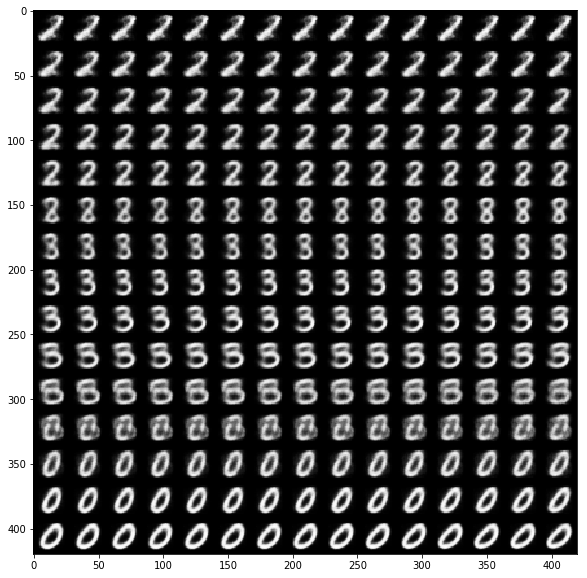

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digits_size = 28
figure = np.zeros((digits_size * n, digits_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.pdf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digits_size, digits_size)
        
        figure[i * digits_size: (i + 1) * digits_size, j * digits_size: (j + 1) * digits_size] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()